In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import re
import string

%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
os.getcwd()

'/content'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Next, I will read in 1000 reviews which I had scrapped from https://www.airlinequality.com/airline-reviews/united-airlines/. The key reason as to why I am comnbining reviews with the tweets is because the tweets are short in nature, and it makes it really hard for any machine learning language model to *learn* based on such a short sequence of words.

In [0]:
UnitedAirlineReviews = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Airline_Tweets/UnitedAirlineReviews.csv')
UnitedAirlineReviews.head()

,reviews_id,Ratings,Title,Reviews,airline_sentiment,Reviews2
0,1,3,"""Disappointing for sure""",Not Verified | Houston to Orange County. Put ...,negative,Houston to Orange County. Put us on plane to...
1,2,1,"""customer service failures""",✅ Trip Verified | Cincinnati to San Antonio v...,negative,Cincinnati to San Antonio via Chicago. Unite...
2,3,2,"""been a total nightmare""",Not Verified | Los Angeles to Richmond via Ch...,negative,Los Angeles to Richmond via Chicago. I shoul...
3,4,1,"""very disappointed""",✅ Trip Verified | Raleigh to Chicago. Flight w...,negative,Raleigh to Chicago. Flight was to leave at 12...
4,5,3,"""delay was unconscionable""",✅ Trip Verified | Fort Lauderdale to Newark. ...,negative,Fort Lauderdale to Newark. The delay on this...


In [0]:
UnitedAirlineReviews = UnitedAirlineReviews[['reviews_id','airline_sentiment','Reviews2']]
UnitedAirlineReviews.head()

,reviews_id,airline_sentiment,Reviews2
0,1,negative,Houston to Orange County. Put us on plane to...
1,2,negative,Cincinnati to San Antonio via Chicago. Unite...
2,3,negative,Los Angeles to Richmond via Chicago. I shoul...
3,4,negative,Raleigh to Chicago. Flight was to leave at 12...
4,5,negative,Fort Lauderdale to Newark. The delay on this...


I will need to make sure that the reviews *columns* match that of the tweets columns before I can do any stacking/concatenation.

In [0]:
UnitedAirlineReviews.columns = ['tweet_id','airline_sentiment','text']
UnitedAirlineReviews.head()

,tweet_id,airline_sentiment,text
0,1,negative,Houston to Orange County. Put us on plane to...
1,2,negative,Cincinnati to San Antonio via Chicago. Unite...
2,3,negative,Los Angeles to Richmond via Chicago. I shoul...
3,4,negative,Raleigh to Chicago. Flight was to leave at 12...
4,5,negative,Fort Lauderdale to Newark. The delay on this...


In [0]:
UnitedAirlineReviews['airline_sentiment'].value_counts()

negative    878
positive     78
neutral      44
Name: airline_sentiment, dtype: int64

As we can see, the reviews data set is overwhelmingly negative, I would need to rebalance the sentiment classes before I can even train a model.

Reading in the tweets files now

In [0]:
UnitedAirlineTweets = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Airline_Tweets/Modified_Tweets_V2.csv',encoding = "ISO-8859-1")

In [0]:
UnitedAirlineTweets.head()

,tweet_id,airline_sentiment,negative_reason,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703061e+17,neutral,Not Applicable,cairdin,0,@united What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,5.703011e+17,positive,Not Applicable,jnardino,0,@united plus you've added commercials to the e...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,5.703011e+17,neutral,Not Applicable,yvonnalynn,0,@united I didn't today... Must mean I need to ...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,Customer Service Issue,jnardino,0,@united it's really aggressive to blast obnoxi...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,5.703008e+17,negative,Reason Can't be Determined,jnardino,0,@united and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
UnitedAirlineTweets['airline_sentiment'].value_counts()

negative    9150
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [0]:
positivetweets = UnitedAirlineTweets[UnitedAirlineTweets['airline_sentiment']=='positive']
positivetweets.head()

,tweet_id,airline_sentiment,negative_reason,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,5.703011e+17,positive,Not Applicable,jnardino,0,@united plus you've added commercials to the e...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
6,5.703006e+17,positive,Not Applicable,cjmcginnis,0,"@united yes, nearly every time I fly VX this ...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
8,5.703000e+17,positive,Not Applicable,dhepburn,0,"@virginamerica Well, I didn't but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,5.702955e+17,positive,Not Applicable,YupitsTate,0,"@united it was amazing, and arrived an hour ea...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)
11,5.702897e+17,positive,Not Applicable,HyperCamiLax,0,@united I &lt;3 pretty graphics. so much bette...,NaN,2015-02-24 10:30:40 -0800,NYC,America/New_York


In [0]:
positivetweets = positivetweets[0:801][['tweet_id','airline_sentiment','text']]
print(positivetweets.shape)


(801, 3)


In [0]:
neutraltweets = UnitedAirlineTweets[UnitedAirlineTweets['airline_sentiment']=='neutral']
neutraltweets.head()

,tweet_id,airline_sentiment,negative_reason,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703061e+17,neutral,Not Applicable,cairdin,0,@united What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
2,5.703011e+17,neutral,Not Applicable,yvonnalynn,0,@united I didn't today... Must mean I need to ...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
7,5.703002e+17,neutral,Not Applicable,pilot,0,@united Really missed a prime opportunity for ...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
10,5.702942e+17,neutral,Not Applicable,idk_but_youtube,0,@united did you know that suicide is the secon...,NaN,2015-02-24 10:48:24 -0800,1/1 loner squad,Eastern Time (US & Canada)
23,5.702588e+17,neutral,Not Applicable,rjlynch21086,0,@united will you be making BOS&gt;LAS non stop...,NaN,2015-02-24 08:27:52 -0800,"Boston, MA",Eastern Time (US & Canada)


In [0]:
neutraltweets = neutraltweets[0:801][['tweet_id','airline_sentiment','text']]
print(neutraltweets.shape)

(801, 3)


In [0]:
UnitedAirlineReviews = pd.concat([UnitedAirlineReviews,positivetweets,neutraltweets])
print(UnitedAirlineReviews.shape)

(2602, 3)


After combining the scraped reviews, neutral tweets, and positive tweets, I would need to inspect the different classes counts first before doing any further text processing.

In [0]:
UnitedAirlineReviews.shape

(2602, 3)

Now, this part is very very important, we will need to randomise the rows first

In [0]:
UnitedAirlineReviews = UnitedAirlineReviews.sample(frac=1,random_state=10)

In [0]:
UnitedAirlineReviews['airline_sentiment'].value_counts()

positive    879
negative    878
neutral     845
Name: airline_sentiment, dtype: int64

## Text Processing steps here

In [0]:
#preparing regex for char filtering
re_punc = re.compile('[%s]'% re.escape(string.punctuation))
strippedpunc = [re_punc.sub('',tweet) for tweet in UnitedAirlineReviews['text']]
UnitedAirlineReviews['text'] = strippedpunc

#Convert to lowercase
UnitedAirlineReviews['text'] = UnitedAirlineReviews['text'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

## Removing stopwords

In [0]:
#Removing stopwords now
import nltk
nltk.download('stopwords')

stop = stopwords.words('english')
UnitedAirlineReviews['text'] = UnitedAirlineReviews['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

UnitedAirlineReviews.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweet_id,airline_sentiment,text
846,8.470000e+02,negative,orlando newark worst airline travelled far fir...
311,3.120000e+02,negative,san francisco tokyo narita united upgraded sea...
4920,5.696445e+17,positive,united thanks
810,8.110000e+02,negative,miami newark travel united airlines always get...
567,5.680000e+02,negative,united airlines staff aguadilla puerto rico ex...


In [0]:
#Removal of extremely frequent words
wordfreq = pd.Series(' '.join(UnitedAirlineReviews['text']).split()).value_counts()[0:30]

wordfreq

united      3155
flight      2436
service      629
us           626
get          617
time         589
would        567
airline      543
airlines     528
plane        474
customer     473
hours        459
one          445
fly          414
never        412
airport      409
told         380
even         364
back         363
flights      352
delayed      349
first        347
gate         328
could        324
got          312
bag          311
seat         292
newark       286
next         284
chicago      283
dtype: int64

In [0]:
wordfreq = list(wordfreq.index)

UnitedAirlineReviews['text'] = UnitedAirlineReviews['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in wordfreq))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
tfidfMatrix = tfidf.fit_transform(UnitedAirlineReviews['text'])
featurenames = tfidf.get_feature_names()

tfidfMatrix

<2602x60027 sparse matrix of type '<class 'numpy.float64'>'
	with 113102 stored elements in Compressed Sparse Row format>

In [0]:
#Checking the shape of the tfidf matrix
print(tfidfMatrix.shape)

(2602, 60027)


In [0]:
#Creating train test split

X_train, X_test, y_train, y_test = train_test_split(tfidfMatrix,UnitedAirlineReviews['airline_sentiment'],test_size=0.25,random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1951, 60027)
(651, 60027)
(1951,)
(651,)


In [0]:
naivebayesM = MultinomialNB().fit(X_train,y_train)
predictedNB = naivebayesM.predict(X_test)
print("Multinomial NB Accuracy Score:",accuracy_score(predictedNB,y_test))

Multinomial NB Accuracy Score: 0.674347158218126


## Text Processing for Deep learning

In [0]:
textlist = []

for text in UnitedAirlineReviews['text']:
    textlist.append(text)

textlist[0:10]

['orlando worst travelled far firstly security staff less due queue long firstly staff ready wait inform secondly rude stuck security due reason staff last people enter dont greet help put cabin cabin head shouted front passengers leave go way passenger treated information arrived 5 boarding slow help crew travel',
 'san francisco tokyo narita upgraded seats premium economy without telling big surprise entire 10 half hour really nice comfortable mileageplus account definitely flying',
 'thanks',
 'miami travel always getting 3rd instance row doesn’t care satisfaction want make money cut cost expense satisfaction happiness executives care much millions make expense customers employees wish better available like singapore cares customers',
 'staff aguadilla puerto rico extremely unprofessional purchased economy doesn’t give staff right talk end day jobs travelers training extremely needed throughout entire especially aguadilla learn treat customers respect idiots traveling',
 'thank nice

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
len(textlist)

2602

In [0]:
max_words = 60000
maxlen = 250
training_samples = 1700
validation_samples = 300


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(textlist)
sequences = tokenizer.texts_to_sequences(textlist)
word_index = tokenizer.word_index
fulldata = pad_sequences(sequences,maxlen=maxlen,padding='post')

In [0]:
print(len(textlist[0]))
print(len(sequences[0]))

312
49


In [0]:
print(fulldata.shape)
print(type(fulldata))

(2602, 250)
<class 'numpy.ndarray'>


In [0]:
from sklearn.preprocessing import LabelEncoder

labels = UnitedAirlineReviews['airline_sentiment']
le = LabelEncoder()
labels = le.fit_transform(labels)

print(labels)

[0 0 2 ... 2 0 2]


In [0]:
np.unique(labels,return_counts=True)

(array([0, 1, 2]), array([878, 845, 879]))

In [0]:
UnitedAirlineReviews['airline_sentiment'].value_counts()

positive    879
negative    878
neutral     845
Name: airline_sentiment, dtype: int64

Negative is 0 , Neutral is 1, Positive is 2

In [0]:
X_train = fulldata[:training_samples]
y_train = labels[:training_samples]
X_val = fulldata[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]
X_test = fulldata[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1700, 250)
(1700, 3)
(300, 250)
(300, 3)
(602, 250)
(602, 3)


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
MLPhistory = model.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_val,y_val))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 250, 100)          6000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                800032    
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 99        
Total params: 6,800,131
Trainable params: 6,800,131
Non-trainable params: 0
_________________________________________________________________
Train on 1700 samples, validate on 300 samples
Epoch 1/10
1700/1700 [==============================] - 3s 1ms/step - loss: 0.8109 - acc: 0.6000 - val_loss: 0.7274 - val_acc: 0.5900
Epoch 2/10
1700/1700 [==============================] - 0s 2

In [0]:
#Evaluate the MLP on the heldout test data
loss, acc = model.evaluate(X_test,y_test)
print(loss)
print(acc)

602/602 [==============================] - 0s 74us/step
0.6589003295399422
0.7873754144903037


In [0]:
##LSTM Model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GRU, Dropout, LSTM

model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(LSTM(120))
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
LSTMhistory = model.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_val,y_val))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 100)          6000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)               106080    
_________________________________________________________________
dense_21 (Dense)             (None, 32)                3872      
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 99        
Total params: 6,110,051
Trainable params: 6,110,051
Non-trainable params: 0
_________________________________________________________________
Train on 1700 samples, validate on 300 samples
Epoch 1/10
1700/1700 [==============================] - 27s 16ms/step - loss: 1.1005 - acc: 0.3359 - val_loss: 1.0997 - val_acc: 0.3033
Epoch 2/10
1700/1700 [==============================] - 25

In [0]:
loss, acc = model.evaluate(X_test,y_test)
print(loss)
print(acc)

602/602 [==============================] - 3s 5ms/step
1.09918124929219
0.3305647846472224


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GRU, Dropout, LSTM, TimeDistributed, Bidirectional
from keras import optimizers

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(96,return_sequences=True),merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(64,activation='relu')))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.summary()

model.compile(optimizer=optimizers.Adam(lr=0.0005),loss='categorical_crossentropy',metrics=['acc'])
BILSTMhistory = model.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_val,y_val))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 100)          6000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 250, 192)          151296    
_________________________________________________________________
dropout_8 (Dropout)          (None, 250, 192)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 250, 64)           12352     
_________________________________________________________________
flatten_8 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)               

In [0]:
loss, acc = model.evaluate(X_test,y_test)
print(loss)
print(acc)

602/602 [==============================] - 6s 10ms/step
1.681529386495039
0.7242524924864404


In [0]:
##Getting the Training history data across all 3 different neural network models
MLPacc = MLPhistory.history['acc']
MLPval_acc = MLPhistory.history['val_acc']
LSTMacc = LSTMhistory.history['acc']
LSTMval_acc = LSTMhistory.history['val_acc']
BILSTMacc = BILSTMhistory.history['acc']
BILSTMval_acc = BILSTMhistory.history['val_acc']

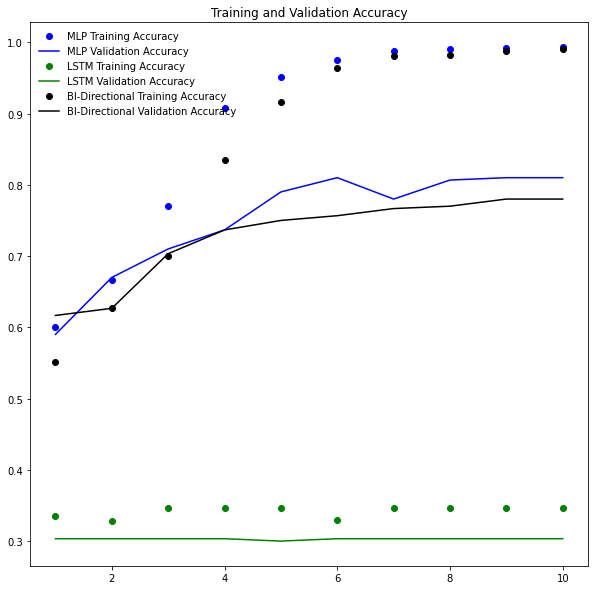

In [0]:
epochs = range(1,len(MLPacc) + 1)
plt.figure(figsize=(10,10))

plt.plot(epochs,MLPacc,'bo',color='blue',label='MLP Training Accuracy')
plt.plot(epochs,MLPval_acc,'b',color='blue',label='MLP Validation Accuracy')
plt.plot(epochs,LSTMacc,'bo',color='green',label='LSTM Training Accuracy')
plt.plot(epochs,LSTMval_acc,'b',color='green',label='LSTM Validation Accuracy')
plt.plot(epochs,BILSTMacc,'bo',color='black',label='BI-Directional Training Accuracy')
plt.plot(epochs,BILSTMval_acc,'b',color='black',label='BI-Directional Validation Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend(loc='upper left',frameon=False)
plt.show()


In [0]:
##Getting the Training history data across all 3 different neural network models
MLPloss = MLPhistory.history['loss']
MLPval_loss = MLPhistory.history['val_loss']
LSTMloss = LSTMhistory.history['loss']
LSTMval_loss = LSTMhistory.history['val_loss']
BILSTMloss = BILSTMhistory.history['loss']
BILSTMval_loss = BILSTMhistory.history['val_loss']

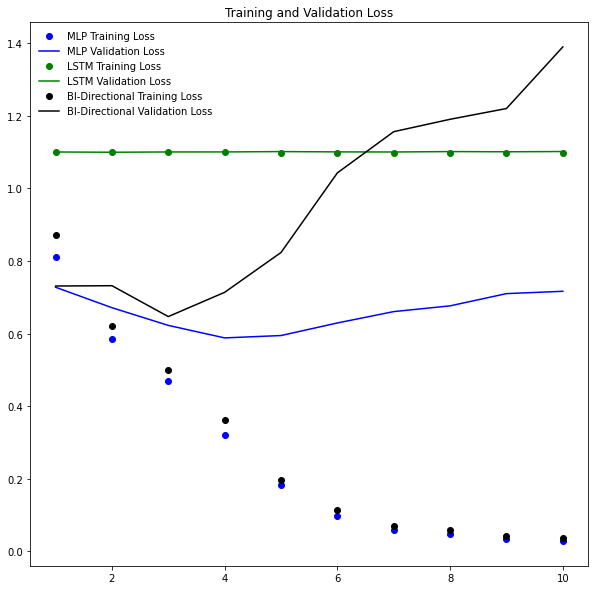

In [0]:
##Plotting the Training and Validation loss across all 3 models

epochs = range(1,len(MLPacc) + 1)
plt.figure(figsize=(10,10))

plt.plot(epochs,MLPloss,'bo',color='blue',label='MLP Training Loss')
plt.plot(epochs,MLPval_loss,'b',color='blue',label='MLP Validation Loss')
plt.plot(epochs,LSTMloss,'bo',color='green',label='LSTM Training Loss')
plt.plot(epochs,LSTMval_loss,'b',color='green',label='LSTM Validation Loss')
plt.plot(epochs,BILSTMloss,'bo',color='black',label='BI-Directional Training Loss')
plt.plot(epochs,BILSTMval_loss,'b',color='black',label='BI-Directional Validation Loss')
plt.title('Training and Validation Loss')

plt.legend(loc='upper left',frameon=False)
plt.show()


To better understand what happen to the model during the entire training phrase, we plotted out both the training and validation accuracy across the 10 epochs. As we would expect, the training accuracy appeared to stall at around the 5th epoch which suggested that the model might be overfitting after the 5th spoch. In this case to avoid overfitting, we can possibly stop training after the 5th epoch. Alternatively, we can try different ways to mitigate overfitting, ranging from using a smaller network size to adding dropout on either visible or hidden layers.

From the accuracy and loss plots above, we observe that the Bi-Directional LSTM model is definitely performing better than the earlier LSTM model. However, before jumping to conclusion too quickly, we note that there is a slight bit of overfitting going on as the training accuracy quickly max out after the 7th and 8th epochs. Likewise, we can also draw a similar conclusion by looking at the loss graph which shows the training loss plateauing after the 8th epoch with minimal improvement with each subsequent epoch.

Now, let us try word embedding using the famous Stanford Glove embedding.

In [0]:
glove_dir = '/content/gdrive/My Drive/Colab Notebooks/Airline_Tweets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


After loading in the Stanford Glove word vector, now let us build an embedding matrix that we will be able to load into an *embedding* layer. It must be a matrix of shape (*max_words,embedding_dim*), where each entry i contains the *embedding_dim* dimension vector for the word of index i in our reference word index (built during tokenisation)

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GRU, Dropout, LSTM, TimeDistributed, Bidirectional
from keras import optimizers

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(96,return_sequences=True),merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(64,activation='relu')))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          6000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 192)          151296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 192)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 250, 64)           12352     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
history = model.fit(X_train,y_train,epochs=18,batch_size=32,validation_data=(X_val,y_val))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1700 samples, validate on 300 samples
Epoch 1/18
1700/1700 [==============================] - 58s 34ms/step - loss: 0.7057 - acc: 0.6753 - val_loss: 0.6470 - val_acc: 0.6800
Epoch 2/18
1700/1700 [==============================] - 56s 33ms/step - loss: 0.5015 - acc: 0.7929 - val_loss: 0.5486 - val_acc: 0.7800
Epoch 3/18
1700/1700 [==============================] - 55s 32ms/step - loss: 0.4243 - acc: 0.8241 - val_loss: 0.5582 - val_acc: 0.7900
Epoch 4/18
1700/1700 [==============================] - 56s 33ms/step - loss: 0.3602 - acc: 0.8471 - val_loss: 0.5161 - val_acc: 0.7833
Epoch 5/18
1700/1700 [==============================] - 56s 33ms/step - loss: 0.3276 - acc: 0.8671 - val_loss: 0.5286 - val_acc: 0.8100
Epoch 6/18
1700/1700 [==============================] - 56s 33ms/step - loss: 0.3066 - acc: 0.8853 - val_loss: 0.5077 - val_acc: 0.8233
Epoch 7/18
1700/1700 [=================

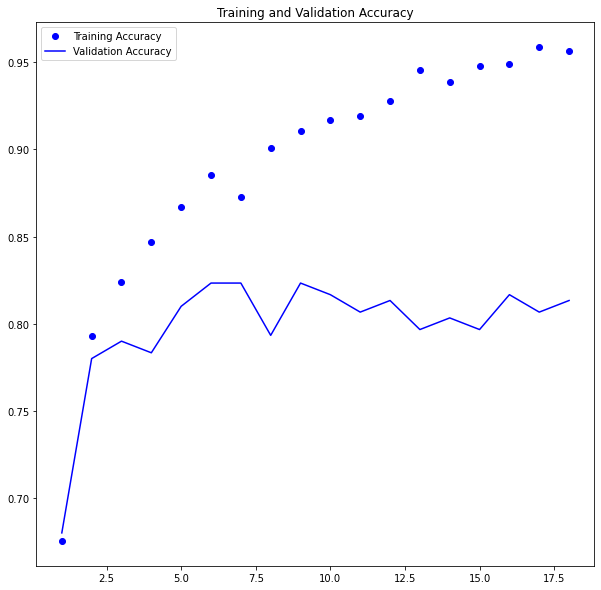

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(acc) + 1)

plt.figure(figsize=(10,10))

plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs, val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()
plt.show()

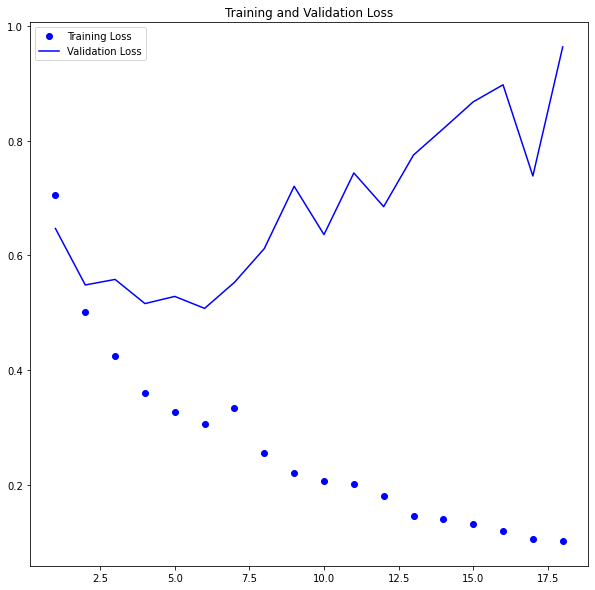

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10,10))

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs, val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

In [0]:
loss, acc = model.evaluate(X_test,y_test)
print(loss)
print(acc)

602/602 [==============================] - 7s 12ms/step
0.9397832129484791
0.7906976750126709


Now, I will use pre-trained work vectors based from tweets. This is trained on 2 billion tweets as compared to the earlier word vector which is trained from Wikipedia articles.

In [0]:
glove_dir = '/content/gdrive/My Drive/Colab Notebooks/Airline_Tweets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GRU, Dropout, LSTM, TimeDistributed, Bidirectional
from keras import optimizers

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(96,return_sequences=True),merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(64,activation='relu')))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          6000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 192)          151296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 192)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 250, 64)           12352     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
history = model.fit(X_train,y_train,epochs=13,batch_size=32,validation_data=(X_val,y_val))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1700 samples, validate on 300 samples
Epoch 1/13
1700/1700 [==============================] - 64s 38ms/step - loss: 0.7458 - acc: 0.6524 - val_loss: 0.5460 - val_acc: 0.8333
Epoch 2/13
1700/1700 [==============================] - 60s 36ms/step - loss: 0.4697 - acc: 0.8206 - val_loss: 0.4856 - val_acc: 0.8400
Epoch 3/13
1700/1700 [==============================] - 61s 36ms/step - loss: 0.3948 - acc: 0.8506 - val_loss: 0.4483 - val_acc: 0.8567
Epoch 4/13
1700/1700 [==============================] - 61s 36ms/step - loss: 0.3496 - acc: 0.8641 - val_loss: 0.4441 - val_acc: 0.8433
Epoch 5/13
1700/1700 [==============================] - 63s 37ms/step - loss: 0.3049 - acc: 0.8712 - val_loss: 0.4891 - val_acc: 0.8467
Epoch 6/13
1700/1700 [==============================] - 62s 37ms/step - loss: 0.2793 - acc: 0.8824 - val_loss: 0.4911 - val_acc: 0.8367
Epoch 7/13
1700/1700 [=================

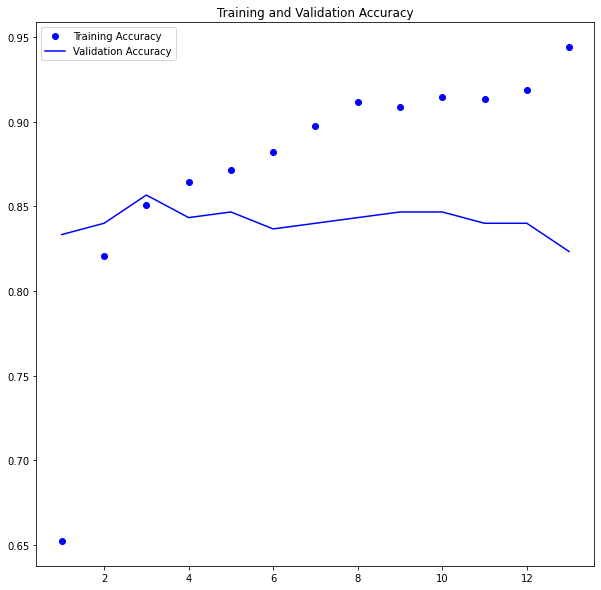

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(acc) + 1)

plt.figure(figsize=(10,10))

plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs, val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()
plt.show()

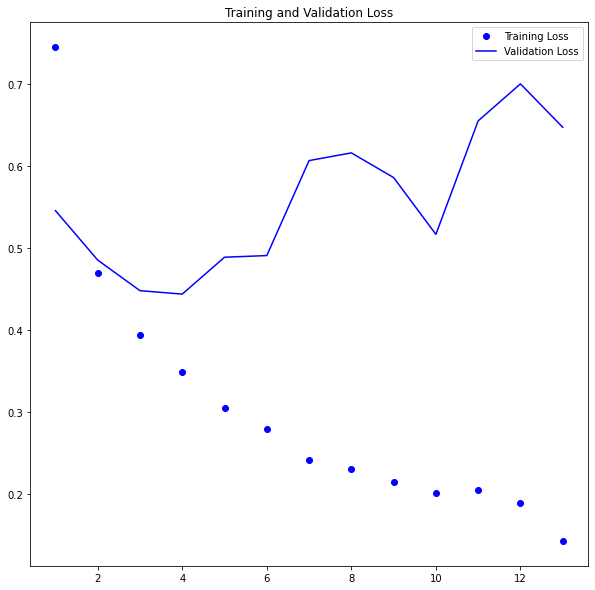

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10,10))

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs, val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

In [0]:
loss, acc = model.evaluate(X_test,y_test)
print(loss)
print(acc)

602/602 [==============================] - 8s 13ms/step
0.6593494952913138
0.8172757479043498


In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Airline_Tweets/')
os.listdir()

['Airlines_Tweets_Reclassified.xlsx',
 'Airlines_Tweets.csv',
 'Airline_Tweets_Analysis.ipynb',
 'Airlinetweets_combined.csv',
 'UnitedAirlineReviews.gsheet',
 'UnitedAirlineReviews.csv',
 'UnitedAirlineReviews_Pos.csv',
 'Airline Reviews V3.ipynb',
 'Airline_Tweets_Analysis_ELmO.ipynb',
 'Airlines_Tweets.gsheet',
 'Modified_Tweets_V2.csv',
 'glove.6B.100d.txt',
 'glove.twitter.27B.100d.txt',
 'Glove_LSTM_model.json',
 'Glove_LSTM_model.h5',
 'sentiment_prediction.ipynb',
 'Airline tweets Analysis_ML LSTM models.ipynb']

In [0]:
##serializing to JSON
from keras.models import model_from_json

model_json = model.to_json()
with open("Glove_LSTM_model.json","w") as json_file:
    json_file.write(model_json)

###Serialise weights to HDF5
model.save_weights("Glove_LSTM_model.h5")
print("Saved model to disk")

Saved model to disk


Now, let us try some sample texts to see how effective the model is!

In [0]:
inputlist = []
user_input = "United is possibly the airline with the worst customer service ever. Please stay away from them at all cost!"
inputlist.append(user_input)

In [0]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(inputlist)
input_sequence = tokenizer.texts_to_sequences(inputlist)
input_sequence = pad_sequences(input_sequence,maxlen=maxlen,padding='post')

In [0]:
tokenizer.word_index

{'airline': 5,
 'all': 17,
 'at': 16,
 'away': 13,
 'cost': 18,
 'customer': 8,
 'ever': 10,
 'from': 14,
 'is': 3,
 'please': 11,
 'possibly': 4,
 'service': 9,
 'stay': 12,
 'the': 1,
 'them': 15,
 'united': 2,
 'with': 6,
 'worst': 7}

In [0]:
predictions = model.predict(input_sequence)
print(np.argmax(predictions))

0


Lets us try to predict on a positive text now!

In [0]:
inputlist = []
user_input = "My wife and I were not able to fly to Maui so we needed to rebook for October 2020. Talked with Loven and he was great to deal with. Took some time but we understood with what’s been going on. He got it all taken care of and it went very smooth. He got our seats moved and we even saved some money. Everything has cleared through the credit card and we are good to go. The other couple that we are going with also had great service and they rebooked with no problem. Thanks United customer service."
inputlist.append(user_input)

In [0]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(inputlist)
input_sequence = tokenizer.texts_to_sequences(inputlist)
input_sequence = pad_sequences(input_sequence,maxlen=maxlen,padding='post')

In [0]:
tokenizer.word_index

{'2020': 27,
 'able': 19,
 'all': 39,
 'also': 63,
 'and': 1,
 'are': 12,
 'been': 37,
 'but': 34,
 'card': 57,
 'care': 41,
 'cleared': 54,
 'couple': 61,
 'credit': 56,
 'customer': 71,
 'deal': 31,
 'even': 49,
 'everything': 52,
 'fly': 20,
 'for': 25,
 'go': 59,
 'going': 8,
 'good': 58,
 'got': 9,
 'great': 6,
 'had': 64,
 'has': 53,
 'he': 5,
 'i': 16,
 'it': 10,
 'loven': 29,
 'maui': 21,
 'money': 51,
 'moved': 48,
 'my': 14,
 'needed': 23,
 'no': 67,
 'not': 18,
 'october': 26,
 'of': 42,
 'on': 38,
 'other': 60,
 'our': 46,
 'problem': 68,
 'rebook': 24,
 'rebooked': 66,
 'saved': 50,
 'seats': 47,
 'service': 13,
 'smooth': 45,
 'so': 22,
 'some': 7,
 'taken': 40,
 'talked': 28,
 'thanks': 69,
 'that': 62,
 'the': 11,
 'they': 65,
 'through': 55,
 'time': 33,
 'to': 2,
 'took': 32,
 'understood': 35,
 'united': 70,
 'very': 44,
 'was': 30,
 'we': 3,
 'went': 43,
 'were': 17,
 'what’s': 36,
 'wife': 15,
 'with': 4}

In [0]:
predictions = model.predict(input_sequence)
print(np.argmax(predictions))

0


In [0]:
predictions

array([[0.9943697 , 0.00202028, 0.00361011]], dtype=float32)